##### Import Necessary Libraries

In [1]:
import pandas as pd
import yfinance as yf
import datetime
from datetime import date, timedelta

today = date.today()

d1 = today.strftime("%Y-%m-%d")
end_date = d1
d2 = date.today() - timedelta(days=365)
d2 = d2.strftime("%Y-%m-%d")
start_date = d2


In [2]:
# load data
data = yf.download('GOOG', 
                      start=start_date, 
                      end=end_date, 
                      progress=False)
data["Date"] = data.index
data = data[["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]]
data
data.reset_index(drop=True, inplace=True)
print(data.tail())

          Date        Open        High         Low       Close   Adj Close  \
246 2024-10-15  167.139999  169.089996  166.050003  166.899994  166.899994   
247 2024-10-16  166.029999  167.279999  165.216003  166.740005  166.740005   
248 2024-10-17  167.380005  167.929993  164.369995  164.509995  164.509995   
249 2024-10-18  164.869995  166.369995  164.750000  165.050003  165.050003   
250 2024-10-21  164.580002  166.220001  164.304993  165.800003  165.800003   

       Volume  
246  14829300  
247   9968500  
248  15113400  
249  13091300  
250  11374300  


In [3]:
# we only need date and close prices column for the rest of the tasks
data = data[["Date", "Close"]]
print(data.head())

        Date       Close
0 2023-10-23  137.899994
1 2023-10-24  140.119995
2 2023-10-25  126.669998
3 2023-10-26  123.440002
4 2023-10-27  123.400002


Text(0, 0.5, 'Close')

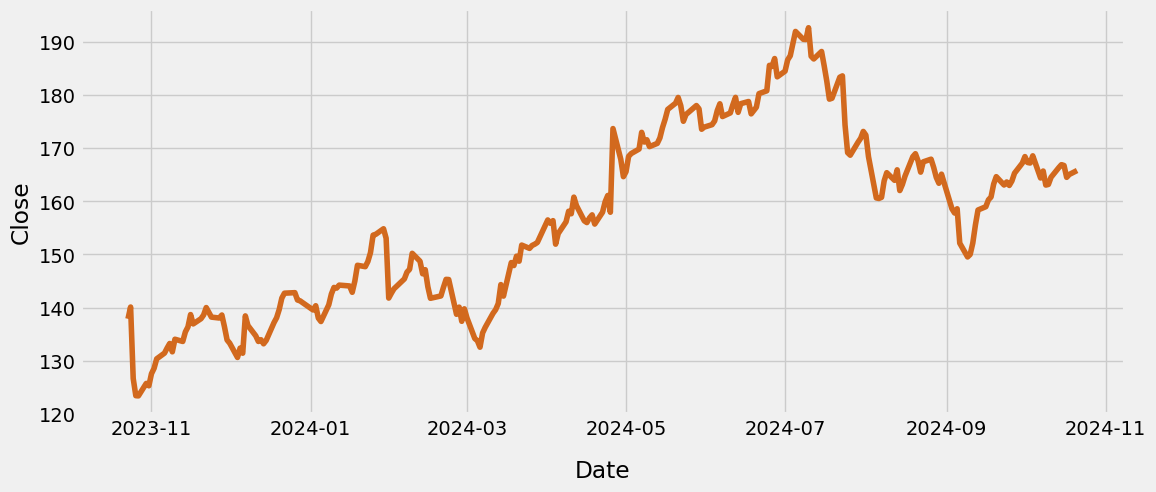

In [4]:
# let's visualize the close prices of the google before moving forward
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
plt.figure(figsize=(12, 5))
plt.plot(data["Date"], data["Close"], color="chocolate")
plt.xlabel("Date", labelpad=15)   #xlabel_obj = plt.xlabel("X-axis Title")
plt.ylabel("Close")               #xlabel_obj.set_position((0.5, -0.1)


<Figure size 640x480 with 0 Axes>

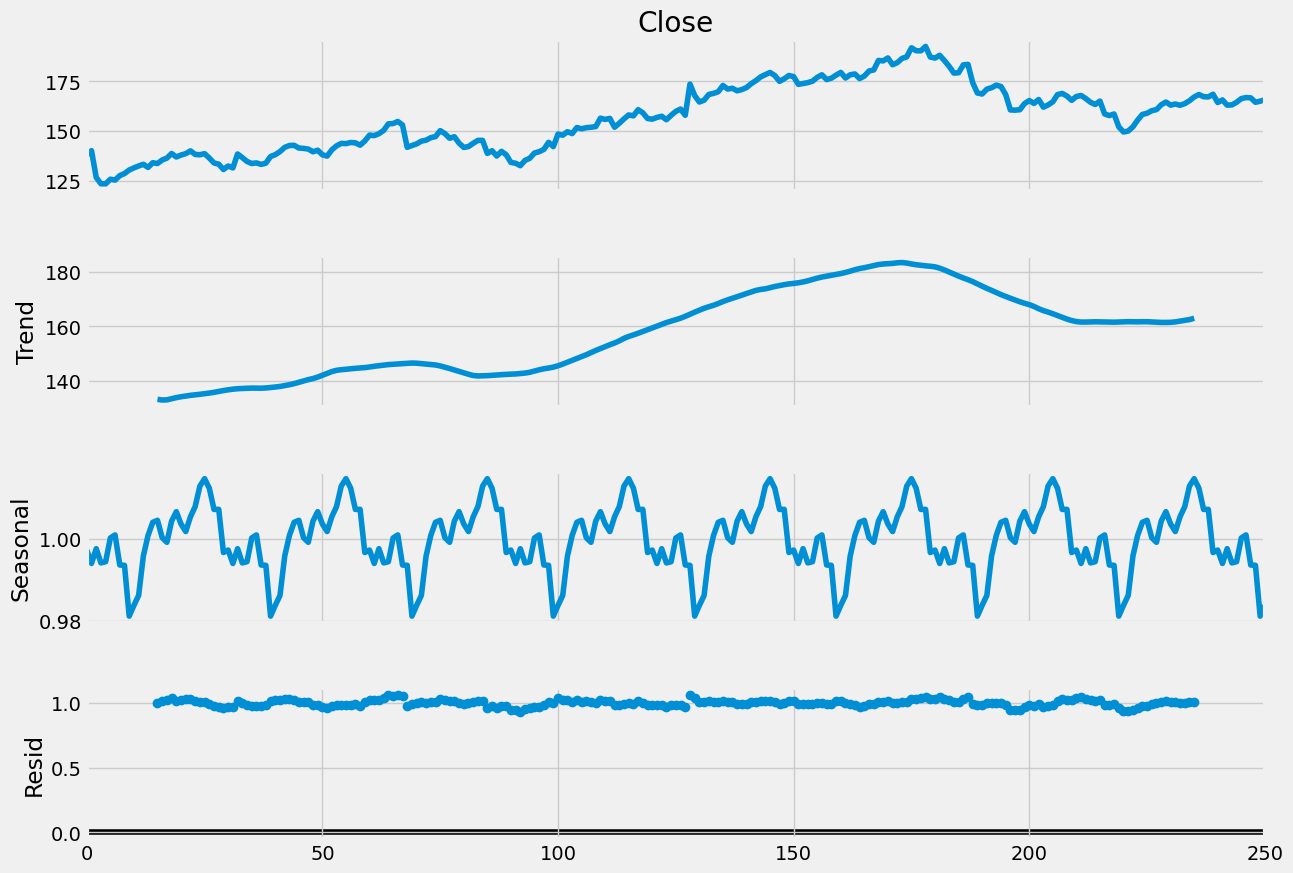

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data["Close"], 
                            model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 10)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

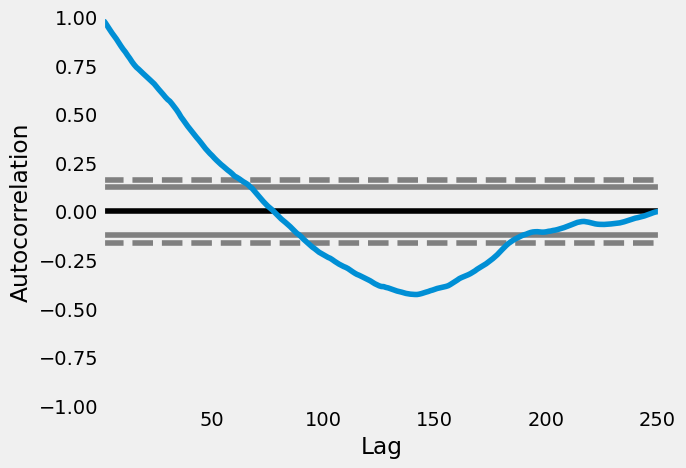

In [6]:
# So our data is not stationary it is seasonal
pd.plotting.autocorrelation_plot(data["Close"])

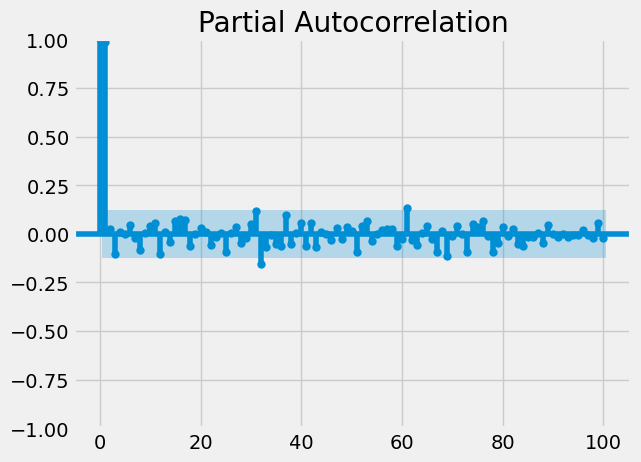

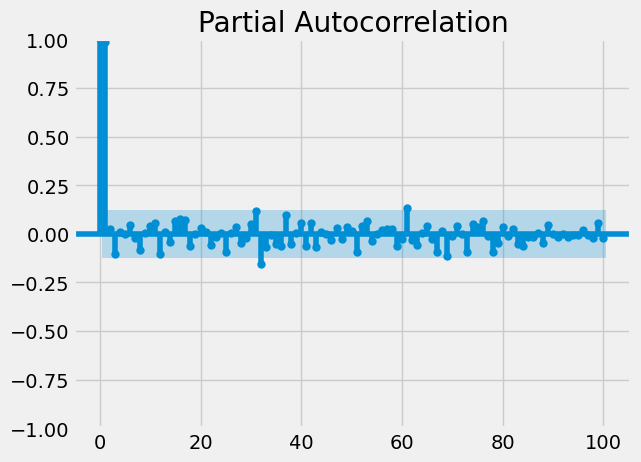

In [7]:
from statsmodels.graphics.tsaplots import  plot_pacf
plot_pacf(data["Close"], lags=100)

In [8]:
p, d, q = 5, 1, 2
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(data["Close"], order=(p,d,q))  
fitted = model.fit()  
print(fitted.summary())

c:\Users\thars\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\thars\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  251
Model:                 ARIMA(5, 1, 2)   Log Likelihood                -596.086
Date:                Tue, 22 Oct 2024   AIC                           1208.172
Time:                        14:06:06   BIC                           1236.344
Sample:                             0   HQIC                          1219.511
                                - 251                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5021      0.059     -8.453      0.000      -0.619      -0.386
ar.L2         -0.9567      0.095    -10.075      0.000      -1.143      -0.771
ar.L3         -0.1001      0.113     -0.883      0.3

c:\Users\thars\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [9]:
#Here’s how to predict the values using the ARIMA model:
predictions = fitted.predict()
print(predictions)

0        0.000000
1      137.899984
2      140.097878
3      126.770973
4      123.519975
          ...    
246    166.279350
247    165.888040
248    167.121446
249    165.039503
250    164.106867
Name: predicted_mean, Length: 251, dtype: float64


In [10]:
#The predicted values are wrong because the data is seasonal. ARIMA model will never perform well on seasonal time 
# series data. So, here’s how to build a SARIMA model:
import statsmodels.api as sm
import warnings
model=sm.tsa.statespace.SARIMAX(data['Close'],
                                order=(p, d, q),
                                seasonal_order=(p, d, q, 12))
model=model.fit()
print(model.summary())


c:\Users\thars\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  251
Model:             SARIMAX(5, 1, 2)x(5, 1, 2, 12)   Log Likelihood                -582.324
Date:                            Tue, 22 Oct 2024   AIC                           1194.648
Time:                                    14:06:41   BIC                           1246.732
Sample:                                         0   HQIC                          1215.638
                                            - 251                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6281      0.091      6.903      0.000       0.450       0.806
ar.L2         -0.9316      0.101   

In [14]:
# Now let’s predict the future stock prices using the SARIMA model for the next 10 days:
predictions = model.predict(len(data), len(data) + 20)
print(predictions)

251    166.437393
252    168.274463
253    168.520585
254    167.441990
255    167.446891
256    168.993457
257    169.740882
258    170.844890
259    170.351672
260    170.211551
261    170.017733
262    170.251735
263    171.356145
264    171.429966
265    171.679537
266    170.243030
267    169.766038
268    170.552211
269    171.421670
270    171.922560
271    171.416063
Name: predicted_mean, dtype: float64


<Axes: >

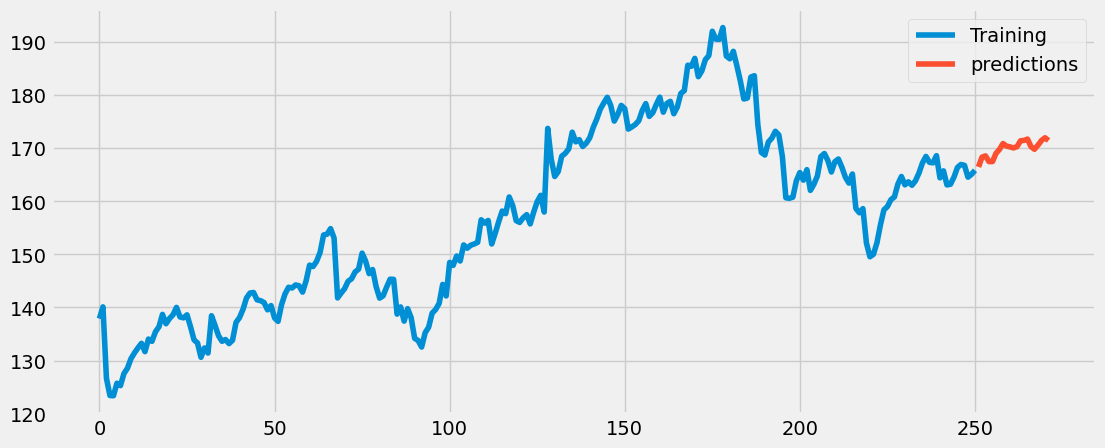

In [15]:
# Here's how you can plot the predictions using pandas
data["Close"].plot(legend=True, label="Training", figsize=(12, 5))
predictions.plot(legend=True, label="predictions")